In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [54]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns

import pfjax as pf
from pfjax import proj_data, PGNETModel
import matplotlib.pyplot as plt

key = random.PRNGKey(1)

# parameter values

theta = np.array([0.1, 0.7, 0.35, 0.2, 0.1, 0.9, 0.3, 0.1])
tau = np.array([1,1,1,1])*1
x0 = jnp.log(jnp.array([8., 8., 8., 5.]))
theta = np.concatenate([theta, tau, x0])
dt = .1
n_res = 1
n_obs = 2
pgnet_model = PGNETModel(dt, n_res)
key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 4))],
                   [jnp.log(jnp.array([8., 8., 8., 5.]))]])

y_meas, x_state = pf.simulate(pgnet_model, subkey, n_obs, x_init, theta)


In [46]:
x_state

DeviceArray([[[2.07944154, 2.07944154, 2.07944154, 1.60943791]],

             [[2.27842468, 1.77442996, 1.78688542, 1.10391032]]],            dtype=float64)

In [47]:
y_meas

DeviceArray([[2.08200274, 2.07220458, 2.08306848, 1.61449393],
             [2.29230468, 1.78266132, 1.7865462 , 1.08801386]],            dtype=float64)

Text(0.5, 1.0, 'Observations and Latent')

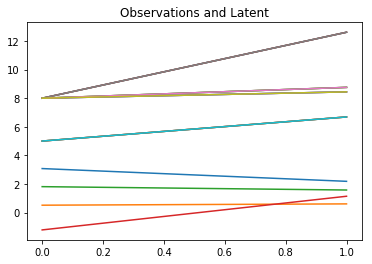

In [12]:
import matplotlib.pyplot as plt
plt.plot(y_meas[:, 0])
plt.plot(y_meas[:, 1])
plt.plot(y_meas[:, 2])
plt.plot(y_meas[:, 3])
plt.plot(np.exp(x_state[:,0]))
plt.plot(np.exp(x_state[:, 1]))
plt.plot(np.exp(x_state[:, 2]))
plt.plot(np.exp(x_state[:, 3]))
plt.title("Observations and Latent")

In [ ]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot


@jax.jit
def pgnet_loglik(theta):
    return pf.full_loglik(model=pgnet_model, theta=theta, x_state=x_state, y_meas=y_meas)


plot_df = proj_data(pgnet_loglik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [ ]:
theta_lims = np.array([[0, 0.5], [0,1], [0, 0.5], [0, 0.5], [0, 0.5], [0.5, 1], [0, 0.5], [0, 0.5],
                     [.1, .5], [.1, .5], [.1, .5], [.1, .5]])
theta_names = ["theta0", "theta1", "theta2", "theta3",
               "theta4", "theta5", "theta6", "theta7",
               "tau0", "tau1", "tau2", "tau3"]
n_pts = 100

# calculate projection plot
n_particles = 1000

@jax.jit
def pgnet_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=pgnet_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(pgnet_pflik,
                    theta, theta_lims, theta_names)

sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

In [55]:
n_particles = 1000
particles = jax.jit(pf.particle_filter, static_argnums=(0,4, 6))(theta=theta, model=pgnet_model, y_meas=y_meas,
                               n_particles=n_particles, key=key)

particles2 = jax.jit(pf.particle_filter, static_argnums=(0,4, 6))(theta=theta, model=pgnet_model, y_meas=y_meas,
                               n_particles=n_particles, key=key, method='bridge')

In [56]:
np.isclose(min(particles2['logw'][1]), max(particles2['logw'][1]))

True

In [57]:
t_obs= 1
n_samples = 10000

# Bootstrap
x_particles = particles['x_particles'][t_obs, :, 0]
logw = particles['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
#x_sample = random.choice(key, a=1000, shape=(n_samples,), p=prob)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample = x_particles[ind]

# Bridge
x_particles2 = particles2['x_particles'][t_obs, :, 0]
logw = particles2['logw'][t_obs]
wgt = jnp.exp(logw - jnp.max(logw))
prob = wgt / jnp.sum(wgt)
#x_sample2 = random.choice(key, a=x_particles2[:,0], shape=(n_samples,), p=prob)
ind = random.choice(key, a=n_particles, shape=(n_samples,), p=prob)
x_sample2 = x_particles2[ind]

Text(0.5, 0.98, 'Density plots for observation 1')

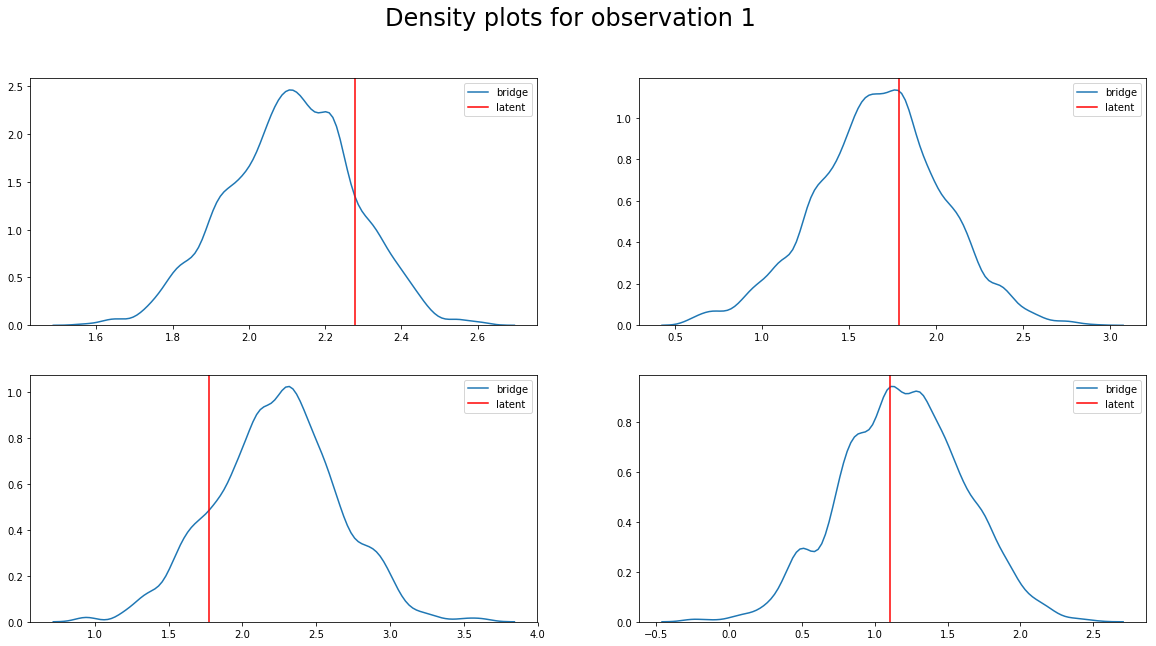

In [64]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(4):
    a,b = i % 2, i//2
    #sns.kdeplot(data=x_sample[:,i], ax=axs[a,b], label='bootstrap')
    sns.kdeplot(data=x_sample2[:,i], ax=axs[a,b], label='bridge')
    axs[a,b].axvline(x=x_state[1, 0, i], label='latent', color='red')
    #axs[a,b].axvline(x=y_meas[1,i], label='noisy obs', color='red')
    #sns.histplot(data=x_sample[:,i], ax=axs[a,b], kde=True, label='bootstrap', alpha=0.2, stat='density')
    #sns.histplot(data=x_sample2[:,i], ax=axs[a,b], kde=True, color='orange', 
    #             label='bridge',alpha=0.2, stat='density')
    axs[a,b].legend()
fig.suptitle('Density plots for observation {}'.format(t_obs), fontsize=24)

In [39]:
y_meas[1]

DeviceArray([2.16997275, 2.51557643, 2.12763051, 1.89264253], dtype=float64)

In [66]:
t_obs= 1
n_samples = 10000

# Bootstrap
x_particles = particles['x_particles'][t_obs, :, 0]
ind = random.choice(key, a=n_particles, shape=(n_samples,))
x_sample = x_particles[ind]

# Bridge
x_particles2 = particles2['x_particles'][t_obs, :, 0]
ind = random.choice(key, a=n_particles, shape=(n_samples,))
x_sample2 = x_particles2[ind]

Text(0.5, 0.98, 'Density plots for observation 1')

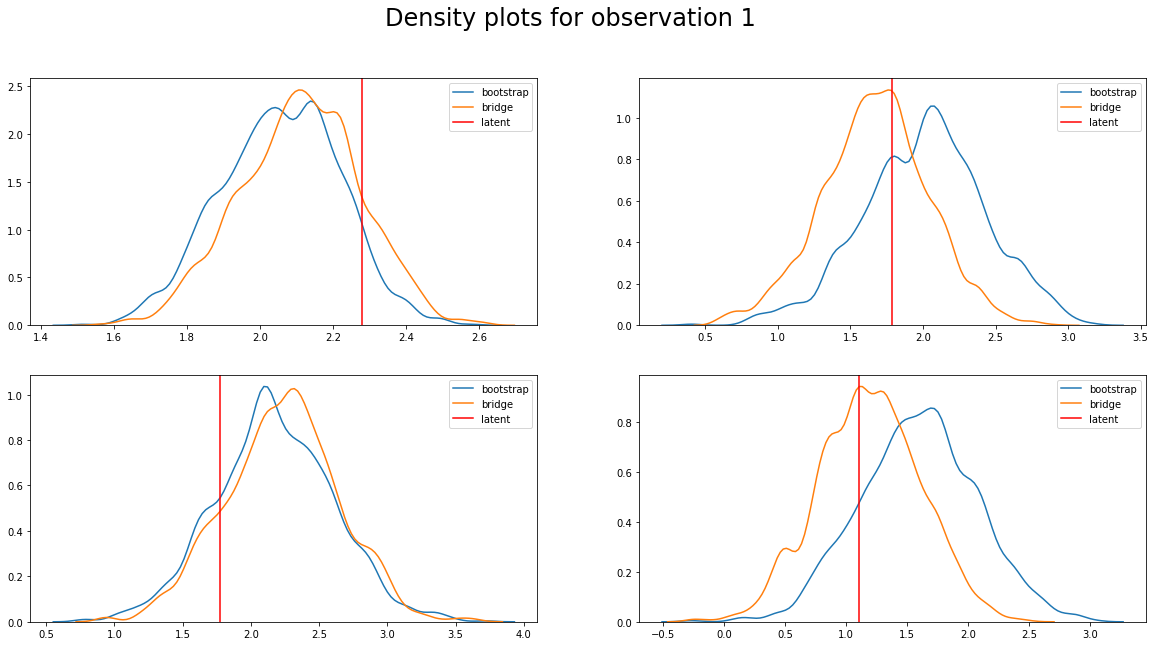

In [67]:
import seaborn as sns
fig, axs = plt.subplots(2, 2, figsize=(20,10))
for i in range(4):
    a,b = i % 2, i//2
    sns.kdeplot(data=x_sample[:,i], ax=axs[a,b], label='bootstrap')
    sns.kdeplot(data=x_sample2[:,i], ax=axs[a,b], label='bridge')
    axs[a,b].axvline(x=x_state[1, 0, i], label='latent', color='red')
    #sns.histplot(data=x_sample[:,i], ax=axs[a,b], kde=True, label='bootstrap', alpha=0.2, stat='density')
    #sns.histplot(data=x_sample2[:,i], ax=axs[a,b], kde=True, color='orange', 
    #             label='bridge',alpha=0.2, stat='density')
    axs[a,b].legend()
fig.suptitle('Density plots for observation {}'.format(t_obs), fontsize=24)